# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [172]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import findspark
import zipfile
findspark.init('/opt/spark/spark-2.3.2-bin-hadoop2.7/')

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.functions import explode

from pyspark.sql.types import StringType
from pyspark.sql.types import TimestampType

from pyspark.sql import SparkSession
from pyspark import SparkContext

from math import floor

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

DATA_DIR = 'data/'

In [5]:
QUESTION_ID = 1
ANSWER_ID = 2

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

**Hint:** Load the dataset from the Parquet file for the next tasks.

In [2]:
#Load the data
posts_rdd = spark.read.json(DATA_DIR + "Posts.json")

#Display dataset
posts_rdd.show(5)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26T03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26T03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26T03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26T03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26T03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 5 

In [3]:
#CreationDate handling
#Changing weird dates and time to TimeStamp spark variable
posts_rdd = posts_rdd.withColumn('CreationDate', posts_rdd['CreationDate'].cast(TimestampType()))

#Display dataset with corrected time and dates
posts_rdd.show(5)

+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|     Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
|2010-10-26 03:17:...|4020437|    null|         1|    0|<asp.net-mvc><jqu...|display jquery di...|      510|
|2010-10-26 03:18:...|4020438|    null|         1|    0|<javascript><html...|Why can only my m...|       62|
|2010-10-26 03:19:...|4020440| 4020214|         2|    1|                null|                null|     null|
|2010-10-26 03:19:...|4020441| 3938154|         2|    0|                null|                null|     null|
|2010-10-26 03:20:...|4020443| 4020419|         2|  324|                null|                null|     null|
+--------------------+-------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 5 

In [4]:
#Create Parquet file
posts_rdd.write.mode("overwrite").parquet(DATA_DIR + "Posts.parquet")

In [7]:
#Load and work on Parquet file
posts_parquet = spark.read.parquet(DATA_DIR + "Posts.parquet")

__1. How many questions have been asked on StackOverflow?__

In [8]:
#Get number of questions
questions_num = posts_parquet.filter(posts_parquet.PostTypeId == QUESTION_ID).count()
print('Number of questions:', questions_num)

Number of questions: 15647060


__2. How many answers have been given?__

In [9]:
#Get number of answers
answers_num = posts_parquet.filter(posts_parquet.PostTypeId == ANSWER_ID).count()
print('Number of answers:', answers_num)

Number of answers: 25192772


__3. What is the percentage of questions with a score of 0?__

In [11]:
#Get proportion of answers with score 0
zero_questions = posts_parquet\
                    .filter(posts_parquet.PostTypeId == QUESTION_ID)\
                    .filter(posts_parquet.Score == 0)\
                    .count()*100/questions_num
print('Proportion of questions with a score of 0:', "%.2f" % zero_questions, '%')

Proportion of questions with a score of 0: 46.54 %


Note that we interpreted the question as meaning "out of all questions, how many have the score 0".

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

In [12]:
#Cleaning and extracting question Id and Tags
    #As seen in part A, there are sometime multiple Tags per question Id (each tag in <...>)
    #Here, the Tags of the questions are separated into multiple rows with the same Id
    
tags_rdd = posts_parquet\
                        .filter(posts_parquet.PostTypeId == QUESTION_ID)\
                        .select('Id', 'Tags')\
                        .withColumn('Tags',explode(split('Tags','><')))\
                        .withColumn('Tags',regexp_replace('Tags','[><]', ''))

#Display separated and cleaned Tags with respective question Id
tags_rdd.show(5)

#Create Parquet file
tags_rdd.write.mode("overwrite").parquet(DATA_DIR + "Tags.parquet")

+--------+------------+
|      Id|        Tags|
+--------+------------+
|45740348|       flash|
|45740348|react-native|
|45740355|  postgresql|
|45740355|  formatting|
|45740355|     plpgsql|
+--------+------------+
only showing top 5 rows



In [13]:
#Load and work on Parquet file
tags_parquet = spark.read.parquet(DATA_DIR + "Tags.parquet")

In [24]:
#Proportion of tags that appear in less than 100 questions
tags_count = tags_parquet\
                .groupby('Tags')\
                .count()\
                .selectExpr('Tags as Tags', 'count as Tags_Occurrence') #rename the columns

#Display tags and corresponding occurence in questions
tags_count.show(5)

+------------+---------------+
|        Tags|Tags_Occurrence|
+------------+---------------+
|     sd-card|           1239|
|   standards|           2495|
|        rxjs|           7960|
|fuzzy-search|            600|
|   arguments|           7157|
+------------+---------------+
only showing top 5 rows



__1. What is the proportion of tags that appear in fewer than 100 questions?__

In [25]:
#Calculation proportion of tags that appear in less than 100 questions
tags100_prop = tags_count\
                .filter(tags_count.Tags_Occurrence < 100)\
                .count()*100/tags_count.count()

print('Proportion of tags that appear in less than 100 questions:', "%.2f" % tags100_prop, '%')

Proportion of tags that appear in less than 100 questions: 67.98 %


__2. Plot the distribution of the tag counts using an appropriate representation.__

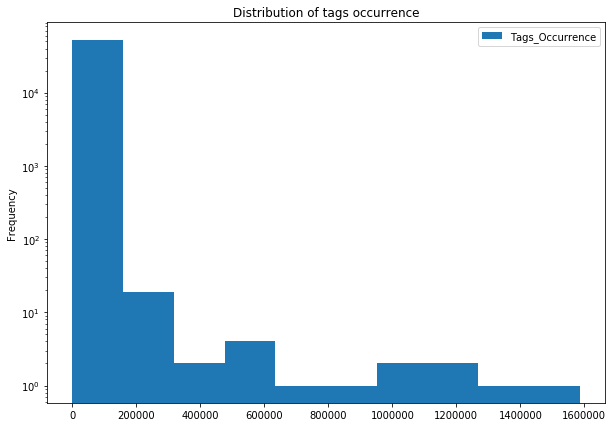

In [66]:
#Plot the frequency at which a tag appear in a certain number of questions
tags_count.toPandas().plot(
                        kind='hist',
                        by='Tags_Occurrence',
                        title='Distribution of tags occurrence',
                        logy=True,
                        figsize=(10, 7)
                        )

__3. Plot a bar chart with the number of questions for the 10 most popular tags.__


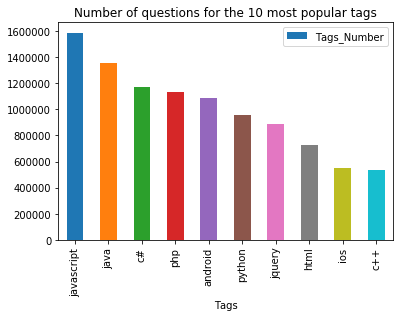

In [67]:
#Select 10 most popular tags overall (questions and answers)
#(Chose "sort + limit" over "top" function to avoid unnecessary conversions)
top10_tags = tags_count\
                .sort(desc('Tags_Occurrence'))\
                .select('Tags')\
                .limit(10)

#Filter question Id associated to each tag
top10_tags_ids = top10_tags\
                    .join(tags_parquet, on=['Tags'])\
                    .groupby('Tags')\
                    .count()\
                    .selectExpr('Tags as Tags', 'count as Tags_Number')\
                    .sort(desc('Tags_Number'))

#Display results in bar chart
top10_tags_ids.toPandas().plot(
                            kind='bar',
                            x='Tags',
                            y='Tags_Number',
                            title='Number of questions for the 10 most popular tags'
                            )

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [54]:
#Extract view count and score of questions with 'random-effects' tag
view_score_rdd = posts_parquet\
                    .filter(posts_parquet.PostTypeId == 1)\
                    .select('Id', 'Score', 'Tags', 'ViewCount')\
                    .withColumn('Tags',explode(split('Tags','><')))\
                    .withColumn('Tags',regexp_replace('Tags','[><]', ''))\
                    .filter("Tags like 'random-effects'")\
                    .drop('Id', 'Tags')

#Create Pandas dataframe for plotting
view_score_pandas = view_score_rdd.toPandas()
view_score_pandas.head(10)

+-----+---------+
|Score|ViewCount|
+-----+---------+
|    0|       12|
|    0|      495|
|    0|      220|
|    0|       21|
|    5|      126|
+-----+---------+
only showing top 5 rows



,Score,ViewCount
0,0,12
1,0,495
2,0,220
3,0,21
4,5,126
5,-1,61
6,0,196
7,1,131
8,2,487
9,4,125


In [55]:
#View the data
view_score_pandas.describe()

,Score,ViewCount
count,100.000000,100.000000
mean,1.500000,1191.830000
std,4.154832,5037.166977
min,-2.000000,10.000000
25%,0.000000,64.250000
50%,0.000000,179.000000
75%,1.000000,534.000000
max,31.000000,42678.000000


Relation between Score and View Count:
 -> Blue line: best fit linear regression
 -> Shaded zone: Confidence interval for the regession estimate


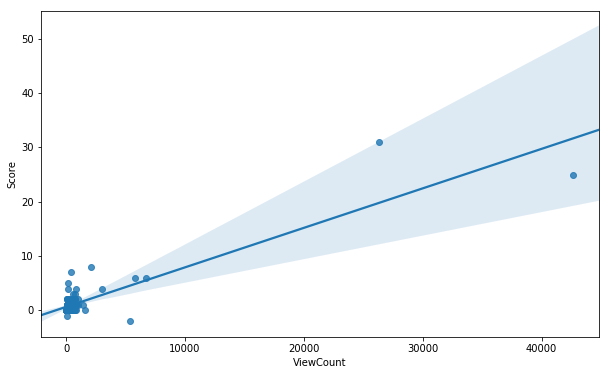

In [75]:
#Plot the Score in relation to the ViewCount
pylab.rcParams['figure.figsize'] = (10, 6) #(bigger)
sns.regplot(x=view_score_pandas['ViewCount'], y=view_score_pandas['Score'])
print('Relation between Score and View Count:')
print(' -> Blue line: best fit linear regression')
print(' -> Shaded zone: Confidence interval for the regession estimate')

In [57]:
#We see in the stats (and on the graph) that the max ViewCount is much bigger than the mean, meaning outliers. 
#We remove these.
normal_view_score = view_score_pandas[view_score_pandas['ViewCount']<20000]

Relation between Score and View Count without outliers:
 -> Blue line: best fit linear regression
 -> Shaded zone: Confidence interval for the regession estimate


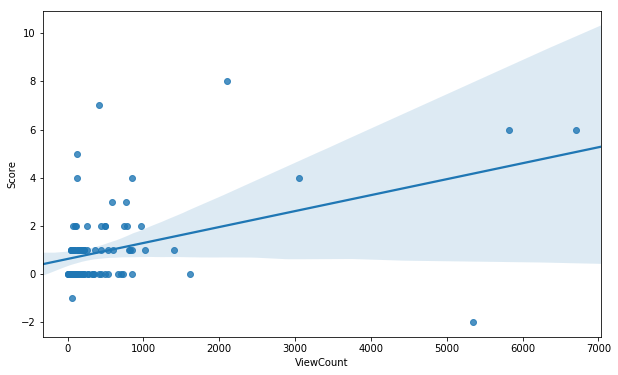

In [76]:
sns.regplot(x=normal_view_score['ViewCount'], y=normal_view_score['Score'])
print('Relation between Score and View Count without outliers:')
print(' -> Blue line: best fit linear regression')
print(' -> Shaded zone: Confidence interval for the regession estimate')

In [71]:
#Pearson coefficients with and without outliers
print('Pearson Score:')
display(view_score_pandas.corr(method='pearson'))
print('\n')
print('Pearson Score without outliers:')
display(normal_view_score.corr(method='pearson'))

Pearson Score:


,Score,ViewCount
Score,1.000000,0.882197
ViewCount,0.882197,1.000000




Pearson Score without outliers:


,Score,ViewCount
Score,1.000000,0.439389
ViewCount,0.439389,1.000000


### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


__ 1) Get the response time for the first answer of the questions with the tags python and java.__

In [91]:
questions_rdd = posts_parquet.filter('PostTypeId == 1')
answers_rdd = posts_parquet.filter('PostTypeId == 2')

earliest_answers = answers_rdd.groupBy('ParentId').agg(min('CreationDate'))\
                       .withColumnRenamed('ParentId', 'Id').withColumnRenamed('min(CreationDate)', 'AnswerDate')

def getMinResponseTime(questions):
    q_and_a = questions.join(earliest_answers, 'Id')
    return q_and_a.rdd.map(lambda r: (r['AnswerDate'] - r['CreationDate']).total_seconds())

In [92]:
python_questions = questions_rdd.filter("Tags like '%<python>%'").select('Id', 'CreationDate')
java_questions = questions_rdd.filter("Tags like '%<java>%'").select('Id', 'CreationDate')

In [93]:
python_response_time = getMinResponseTime(python_questions)
python_response_time.take(5)

[7398.97, 5088.38, 510.994, 756.637, 116.33]

In [95]:
java_response_time = getMinResponseTime(java_questions)
java_response_time.take(5)

[1921.887, 439.077, 290.054, 155.953, 3076.006]

__2) Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.__

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2ef2ad19b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2ef2fd92b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2ef2ad1860>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2ef2fd9b00>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2ef2fd9f28>,
 'means': []}

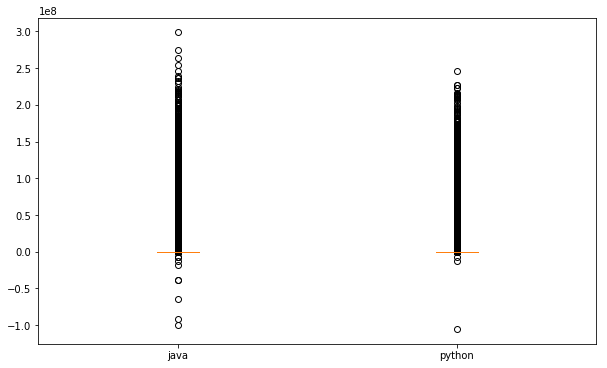

In [101]:
python_time = pd.Series(python_response_time.collect())
java_time = pd.Series(java_response_time.collect())
plt.boxplot([java_time, python_time], labels=['java', 'python'])

In [153]:
print('Means:')
print('   Java: ' + str(java_time.mean()/(3600 * 24)) + ' [days]')
print('   Python: ' + str(python_time.mean()/(3600 * 24)) + ' [days]')

print('Medians:')
print('   Java: ' + str(java_time.median()/(3600)) + ' [hours]')
print('   Python: ' + str(python_time.median()/(3600)) + ' [hours]')

print('Std dec:')
print('   Java: ' + str(java_time.std()/(3600 * 24)) + ' [days]')
print('   Python: ' + str(python_time.std()/(3600 * 24)) + ' [days]')

print('[Java size:  ' + str(java_time.count()) + ']')
print('[Python size: ' + str(python_time.count()) + ']')

Means:
   Java: 11.535157797070434 [days]
   Python: 11.352192907733121 [days]
Medians:
   Java: 0.33826625 [hours]
   Python: 0.37411805555555555 [hours]
Std dec:
   Java: 82.49988358644708 [days]
   Python: 79.86120546182448 [days]
[Java size:  1179070]
[Python size: 830160]


__Discussion:__

We can see that the distributions of java and python tags are almost identical, even though the java tags has slightly more data.

However, we notice that the mean and the median are extremely different.Since we know that means and standard deviations are extremely susceptible to outliers, we can theorize here that there are outliers with very, very late response times.

__3) We believe that the response time is lower for questions related to Python. Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.__

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2ef0936b70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2ef0939470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2ef0936a20>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2ef0939cc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2ef093d128>,
 'means': []}

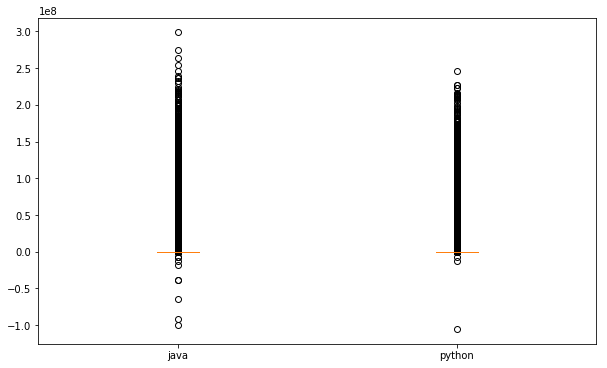

In [104]:
plt.boxplot([java_time, python_time], labels=['java', 'python'], bootstrap=100)

We can see in this boxplot that the median response time of java is in fact slightly lower than python's

__ 4) Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.__

In [129]:
common_tags = tags_count.filter(tags_count.Tags_Occurrence >=5000).rdd.map(lambda r: r[0]).collect()

In [117]:
question_dates = questions_rdd.select('CreationDate', 'Id', 'Tags')\
                    .withColumn('Tags',explode(split('Tags','><')))\
                    .withColumn('Tags',regexp_replace('Tags','[><]', ''))\
                    .toDF('CreationDate', 'Id', 'Tags')

In [132]:
common_tag_questions = question_dates.filter(question_dates['Tags'].isin(common_tags))

In [136]:
response_times = common_tag_questions.join(earliest_answers, 'Id')\
                            .rdd.map(lambda r: (r['Tags'], ((r['AnswerDate'] - r['CreationDate']).total_seconds())))

In [155]:
fastest_resp = response_times.filter(lambda r: r[1] > 0).takeOrdered(10, key= lambda r: r[1])

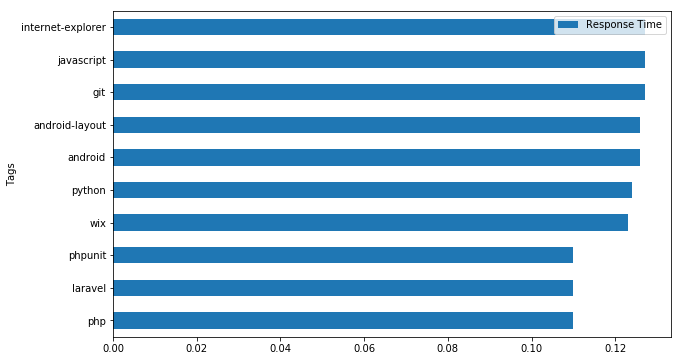

In [157]:
pd.DataFrame(fastest_resp).rename(columns={0:'Tags', 1:'Response Time'}).set_index('Tags').plot(kind='barh')

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


In [173]:
#Interval calculation: 
# 60 (seconds) * 60 (minutes) * 24 (hours) * 30 (days)
intervall = (60*60*24*30)

def getDaysIntervall(dt):
    return floor((dt.timestamp())/intervall) * intervall

In [179]:
# Add your code and description here
thirty_day_quest = questions_rdd.filter("Tags like '%<pyspark>%'")\
                .select('CreationDate').rdd\
                .map(lambda r: (getDaysIntervall(r[0]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda r: (datetime.fromtimestamp(r[0]), r[1]))


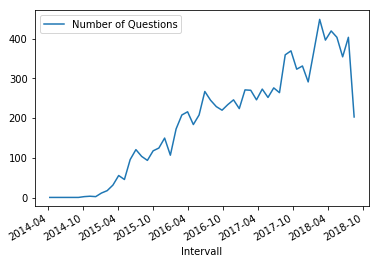

In [181]:
pd.DataFrame(thirty_day_quest.collect())\
                                .rename(columns={0:'Intervall', 1: 'Number of Questions'})\
                                .set_index('Intervall').plot()